In [1]:
import ctypes
import ctypes.util
import numpy as np
import time
import math
import h5py
import warnings
import os
import os.path
import errno
import sys
import scipy.ndimage
import shutil
import utils.utils as utils
import warnings
import gc
import nidaqmx
import os
import os.path
from os import path
%matplotlib notebook
from matplotlib import pyplot as plt

import camera.hamamatsu_camera as hc
import filter_wheel.fw102c_LB as fw102c_LB
import laser.obis as obis
import xyz_stage.ms2000 as ms2000
import generator.ni_LB as generator

In [2]:
galvoXoffset = 2.77 #in V
galvoYoffset =  np.array([-1.185, -1.185]) #for 660nm, 488nm respectively. usually these numbers should be the same for 20X imaging

galvoXamp = 1.90 # in V. should be 1.5V for 20X imaging
galvofreq = 1000 #in Hz. rule of thumb should tune to whatever minimum frequency looks "smooth" on the live camera feed

In [3]:
expTime = 5 #ms 
laser_power = 1 #mW
binFactor = 1
camX = 2048
camY = 256

In [4]:
waveform = generator.waveformGenerator(freq = galvofreq, Xamplitude = galvoXamp, Xoffset = galvoXoffset, Yamplitude = 0, Yoffset = galvoYoffset[0])
laser488 = obis.Obis(baudrate = 9600, port = 'COM3')
laser488.setPower(laser_power)
fWheel = fw102c_LB.FW102C(baudrate = 115200, port = 'COM4')
fWheel.setPosition(488)

[1.0, 16.5]


In [5]:
import camera.hamamatsu_camera as hc
hcam = hc.HamamatsuCameraMR(camera_id=0)
# Set camera properties
hcam.setPropertyValue("defect_correct_mode", "OFF") # keep defect mode on
hcam.setPropertyValue("readout_speed", 2) # 1 or 2. 2 is fastest mode
hcam.setPropertyValue("exposure_time", expTime/1000.0) # convert from msec to sec
hcam.setPropertyValue("subarray_hsize", camX)
hcam.setPropertyValue("subarray_vsize", camY)
hcam.setPropertyValue("subarray_vpos", 1024-camY/2)
hcam.setPropertyValue("binning", binFactor)

# Set trigger properties
hcam.setPropertyValue("trigger_source", 'INTERNAL') # 1 (internal), 2 (external), 3 (software)
hcam.setPropertyValue("trigger_mode", 'START') # 1 (normal), 6 (start)
hcam.setPropertyValue("trigger_active", 'EDGE') # 1 (edge), 2 (level), 3 (syncreadout)
hcam.setPropertyValue("trigger_polarity", 'POSITIVE') # 1 (negative), 2 (positive)
hcam.setACQMode("fixed_length", 1)

 unknown property name: readout_speed
max camera backlog was: 0


In [6]:
xyzStage = ms2000.MS2000(baudrate = 9600, port = 'COM6')
xyzStage.setScanF(1)
xyzStage.setBacklash(0)
xyzStage.setTTL(0)

xyzStage.setVelocity('X',0.5)
xyzStage.setVelocity('Y',0.5)
xyzStage.setVelocity('Z',0.5)

In [7]:
init_pos = [23.5, -21, -1.90]

xyzStage.goAbsolute('X', init_pos[0], False)
xyzStage.goAbsolute('Y', init_pos[1], False)
xyzStage.goAbsolute('Z', init_pos[2], True)

In [6]:
laser488.turnOn()

laser on


In [7]:
time.sleep(1)
hcam.startAcquisition() #start camera acquisition

In [8]:
[frames, dims] = hcam.getFrames()
time.sleep(1)

for aframe in frames:
    data = aframe.getData().astype(np.float32)
    im = np.reshape(data, (camY, camX))


In [9]:
laser488.turnOff()

In [13]:
np.median(im)

110.0

<IPython.core.display.Javascript object>


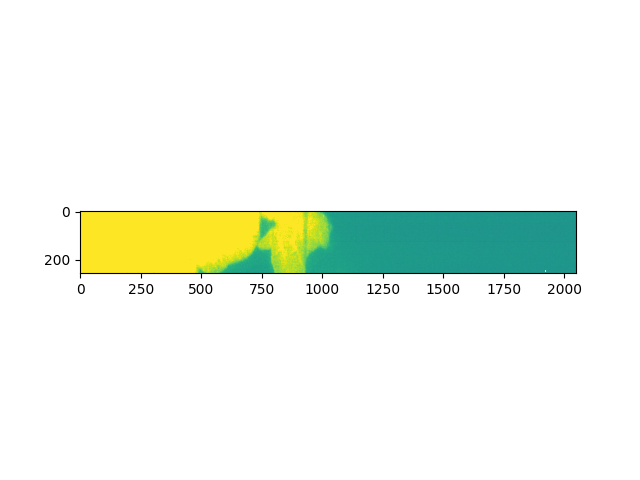

In [10]:
plt.figure()
plt.imshow(im, vmax = 160)

In [11]:
hcam.shutdown()
fWheel.shutDown()
waveform.stop() #stops galvo
laser488.shutDown()
xyzStage.shutDown()

C:\ProgramData\Anaconda3\lib\site-packages\nidaqmx\task.py:463: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<0>" but task was already closed.
  'already closed.'.format(self._saved_name), DaqResourceWarning)


NameError: name 'xyzStage' is not defined